## Jaxifying QVMC

In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import jax
import jax.numpy as jnp
from local_energy import get_local_energy_fn

In [3]:
import jax

In [4]:
import jax.numpy as jnp

def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(1000000)
%timeit selu(x).block_until_ready()

4.49 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
params = jnp.array([0.0])
data = jax.random.uniform(jax.random.key(3), (4200, 3))
key = jax.random.key(3)

In [5]:
from sampling import metropolis_step

In [10]:
def f(params, x):
    return jnp.mean(x)

f_b = jax.vmap(f, in_axes=(None, 0))

In [11]:
mc_step = metropolis_step(params, f_b, data, key)

In [14]:
mc_step_jitted = jax.jit(mc_step)

In [16]:
%timeit mc_step(params, data, key, 0.02)

440 ms ± 8.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit mc_step_jitted(params, data, key, 0.02)

1.82 ms ± 89.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
jitted(params, f, data, key)

TypeError: Cannot interpret value of type <class 'function'> as an abstract array; it does not have a dtype attribute

### Sampling

In [12]:
key = jax.random.key(seed=2)
n_walkers = 4200
n_dim = 3
n_particles = 2
pos = jax.random.normal(
    key, (n_walkers, n_dim * n_particles))

In [13]:
def test_f(x):
    """Assuming ndim input (x)"""
    r2 = jnp.sqrt(jnp.sum(x**2))
    return jnp.mean(x) * jnp.exp(1/r2)

test_f_b = jax.vmap(test_f)  # batched network

In [14]:
# Metropolis
from jax import lax

def mh_accept(x1, x2, lp_1, lp_2, ratio, key, num_accepts):
  """Given state, proposal, and probabilities, execute MH accept/reject step."""
  key, subkey = jax.random.split(key)
  rnd = jnp.log(jax.random.uniform(subkey, shape=ratio.shape))
  cond = ratio > rnd
  cond = cond[:, None]
  x_new = jnp.where(cond, x2, x1)
  lp_new = jnp.where(cond, lp_2, lp_1)
  num_accepts += jnp.sum(cond)
  return x_new, key, lp_new, num_accepts

def metropolis_step(
      params, f, data, key, mcmc_width=0.12):
    
    n_steps = 10

    def step_fn(i, carry):
      data, key, num_accepts = carry
      key, subkey = jax.random.split(key)

      x1 = data
      x2 = x1 + mcmc_width * jax.random.normal(
        subkey, shape=x1.shape)

      lp_1 = 2.0 * f(params, x1)
      lp_2 = 2.0 * f(params, x2)
      ratio = lp_2 - lp_1
      
      x_new, key, lp_new, num_accepts = mh_accept(
        x1, x2, lp_1, lp_2, ratio, key, num_accepts)
      
      return x_new, key, num_accepts
      
    new_data, key, num_accepts = lax.fori_loop(
        0, n_steps, step_fn, (data, key, jnp.array(0))
    )
    pmove = num_accepts / (n_steps * data.shape[0])

    return new_data, pmove

### Network

In [15]:
from networks import MLP, psi_nn

In [16]:
model = MLP(input_dim=3, n_hidden_layers=2, hidden_dim=3, output_size=1)

In [192]:
variables = model.init(key, jax.random.normal(key, 3))
params = variables["params"]

In [229]:
def f(params, x):
    nn_out = model.apply({"params": params}, x)
    r = jnp.linalg.norm(x)
    # Hydrogenic term (example: Z=2)
    hydrogenic = -1.0 * r
    return jnp.squeeze(nn_out) + hydrogenic

### Local Energy

In [207]:
def _lapl_over_f(params, data):
    n = data.shape[0]
    eye = jnp.eye(n)

    grad_f = jax.grad(f, argnums=1)
    
    def grad_f_closure(x):
        return grad_f(params, x)

    primal, dgrad_f = jax.linearize(grad_f_closure, data)

    hessian_diagonal = lambda i: dgrad_f(eye[i])[i]

    result = -0.5 * lax.fori_loop(
        0, n, lambda i, val: val + hessian_diagonal(i), 0.0)
    return result - 0.5 * jnp.sum(primal ** 2)

In [208]:
from local_energy import get_local_energy_fn

In [209]:
local_energy = get_local_energy_fn(f)

In [210]:
e_loc = local_energy(params, pos)
mean_energy = jnp.mean(e_loc)

In [211]:
e_loc

Array([-0.02742211, -0.02419916, -0.02406534, ..., -0.08091354,
       -0.01965621, -0.02805981], dtype=float32)

In [212]:
mean_energy

Array(-0.04365415, dtype=float32)

In [213]:
jnp.mean((e_loc - mean_energy)**2)

Array(0.00097862, dtype=float32)

### Optimization

In [221]:
# not doing it via loss and grad

def energy_loss(params, data):
    eloc = local_energy(params, data)   # (B,)
    return jnp.mean(eloc)


def energy_grads(params, data):
    # ----- forward pass -----
    eloc = local_energy(params, data)          # (B,)
    loss = jnp.mean(eloc)
    diff = eloc - loss                         # (B,)

    # ----- log ψ -----
    log_psi = lambda p: jnp.log(f_b(p, data))  # (B,)

    # ----- VJP -----
    _, vjp_fn = jax.vjp(log_psi, params)

    # Contract batch dimension first
    cotangent = diff / diff.shape[0]            # (B,)

    grads = vjp_fn(cotangent)[0]

    return loss, grads


In [222]:
pos.shape

(4200, 3)

In [223]:
flat_params, ravel_fn = ravel_pytree(params)

In [224]:
loss, grads = energy_grads(params, pos)

In [ ]:
from jax.flatten_util import ravel_pytree

In [149]:
grad_flat, unravel_fn = ravel_pytree(grads)

In [141]:
energy_grads(params, pos)

(Array(-1.0010053, dtype=float32),
 {'Dense_0': {'bias': Array([ 0.03250854, -0.01686911,  0.02931045], dtype=float32),
   'kernel': Array([[ 0.0003809 , -0.00022431,  0.00037943],
          [ 0.00238728, -0.00078759,  0.00232838],
          [-0.00251525,  0.00076611, -0.00235071]], dtype=float32)},
  'Dense_1': {'bias': Array([-0.65068114,  0.6625924 , -0.21817963], dtype=float32),
   'kernel': Array([[-0.02279942,  0.02266682, -0.0076655 ],
          [ 0.00333157, -0.00304474,  0.00200873],
          [ 0.02362109, -0.02323238,  0.00827753]], dtype=float32)},
  'Dense_2': {'bias': Array([0.833125], dtype=float32),
   'kernel': Array([[0.02169407],
          [0.0214928 ],
          [0.00057703]], dtype=float32)}})

In [232]:
import optax
from jax.flatten_util import ravel_pytree

# ------------------
# Optimizer
# ------------------
learning_rate = 2e-2
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# ------------------
# Burn-in
# ------------------
burn_in = 10
for i in range(burn_in):
    pos, pmove = metropolis_step(
        params, f_b, pos, key, mcmc_width=0.12
    )

# ------------------
# Optimization loop
# ------------------
nsteps = 100
for step in range(nsteps):

    # --- MCMC move ---
    pos, pmove = metropolis_step(
        params, f_b, pos, key, mcmc_width=0.12
    )

    # --- Energy + gradients ---
    loss, grads = energy_grads(params, pos)

    # --- Optax update ---
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    print(
        f"Step {step:04d} | "
        f"Energy {loss:.6f} | "
        f"Acceptance {pmove:.3f}"
    )


Step 0000 | Energy -0.022312 | Acceptance 0.999
Step 0001 | Energy -0.023441 | Acceptance 0.999
Step 0002 | Energy -0.022859 | Acceptance 0.999
Step 0003 | Energy -0.022845 | Acceptance 0.998
Step 0004 | Energy -0.023420 | Acceptance 0.999
Step 0005 | Energy -0.023349 | Acceptance 0.999
Step 0006 | Energy -0.022783 | Acceptance 0.999
Step 0007 | Energy -0.023073 | Acceptance 0.999
Step 0008 | Energy -0.022771 | Acceptance 0.998
Step 0009 | Energy -0.023299 | Acceptance 0.998
Step 0010 | Energy -0.023575 | Acceptance 0.999
Step 0011 | Energy -0.023139 | Acceptance 0.998
Step 0012 | Energy -0.022602 | Acceptance 0.998
Step 0013 | Energy -0.023437 | Acceptance 0.998
Step 0014 | Energy -0.023166 | Acceptance 0.998
Step 0015 | Energy -0.022666 | Acceptance 0.998
Step 0016 | Energy -0.021841 | Acceptance 0.998
Step 0017 | Energy -0.021418 | Acceptance 0.998
Step 0018 | Energy -0.021625 | Acceptance 0.998
Step 0019 | Energy -0.021572 | Acceptance 0.998
Step 0020 | Energy -0.021181 | Acceptanc

KeyboardInterrupt: 

In [3]:
from features import radial_and_pairwise_features

In [27]:

batch_size = 4200
n_particles = 2
n_dim = 3

key = jax.random.key(seed=2)
pos = jax.random.normal(key, (batch_size, n_dim * n_particles))

In [28]:
r, rij = radial_and_pairwise_features(pos, 2, 3)

In [29]:
# Flatten features for NN
features = jnp.concatenate(
    [
        r.reshape(r.shape[0], -1),
        rij.reshape(rij.shape[0], -1),
    ],
    axis=1,
)

In [30]:
features.shape

(4200, 3)

In [36]:
model = MLP(input_dim=3, n_hidden_layers=2, hidden_dim=32, output_size=1)
variables = model.init(key, jax.random.normal(key, 3))
params = variables["params"]

In [38]:
model_vmapped = jax.vmap(
    model, in_axes=(None, 0), out_axes=(0))

In [129]:
def f(params, x):
    return model.apply({"params": params}, x)

In [42]:
f_b = jax.vmap(
    f, in_axes=(None, 0), out_axes=(0))

In [112]:
x = jax.random.normal(key, (6,))

In [113]:
def psi_nn_f(params, x):
    return psi_nn(params, f, x, 2, 3)

In [114]:
psi_nn_f(params, x)

(6,)


Array(-5.445209, dtype=float32)

In [88]:
dim = 3
R = x.reshape(n_particles, dim)

# -------------------------
# One-body radii |r_i|
# -------------------------
r = jnp.linalg.norm(R, axis=-1, keepdims=True)   # (N, 1)

# -------------------------
# Pairwise distances |r_i - r_j|
# -------------------------
diff = R[:, None, :] - R[None, :, :]             # (N, N, d)
dist = jnp.linalg.norm(diff, axis=-1)            # (N, N)

# Keep only i < j
i, j = jnp.triu_indices(n_particles, k=1)
rij = dist[i, j][:, None]                         # (n_pairs, 1)


In [119]:
psi_nn(params, f, x, 2, 3)

(6,)


Array(0.068878, dtype=float32)

In [185]:

def psi_nn(
    params,
    model,
    x,
    n_particles,
    dim,
    Z
):
    """
    x: (n_particles * dim,)
    returns: scalar (log ψ)
    """

    # -------------------------
    # Geometric features
    # -------------------------
    r, rij = radial_and_pairwise_features(
        x, n_particles, dim)
    # r   : (N, 1)
    # rij : (N_pairs, 1)

    # -------------------------
    # Flatten features for NN
    # -------------------------
    features = jnp.concatenate(
        [
            r.reshape(-1),     # (N,)
            rij.reshape(-1),   # (N_pairs,)
        ],
        axis=0,
    )         
                    # (N + N_pairs,)
    r1_vec = x[:3]
    r2_vec = x[3:]

    r1 = jnp.linalg.norm(r1_vec, keepdims=True)      # (1,)
    r2 = jnp.linalg.norm(r2_vec, keepdims=True)      # (1,)
    r12 = jnp.linalg.norm(r1_vec - r2_vec, keepdims=True)  # (1,)

    features = jnp.concatenate([r1, r2, r12], axis=0)  # (3,)

    # NN output (assumed scalar)
    nn_out = jnp.squeeze(model(params, features))

    # -------------------------
    # Physics terms
    # -------------------------

    # Electron–nucleus (example Z=1)
    hydrogenic = -Z * jnp.sum(r1) - Z * jnp.sum(r2)      # scalar

    # Electron–electron Jastrow (example form)
    jastrow = jnp.sum(
        r12 / (2.0 * (1.0 + 0.5 * r12))
    )                                     # scalar

    return nn_out + jastrow + hydrogenic

In [186]:
def psi_nn_f(params, x):
    return psi_nn(params, f, x, 2, 3, 2)

In [187]:
psi_nn_f(params, x)

Array(-5.445209, dtype=float32)

In [188]:
jax.grad(psi_nn_f, argnums=1)(params, x)

Array([-0.7769309 , -1.0791783 ,  0.98412496, -1.7024852 , -0.21790573,
        1.3844206 ], dtype=float32)

In [189]:
nelectrons = 2
ndim = 3
Z = 2
def pe(x):
    """
    Full Coulomb potential energy for a single atom at the origin.

    x: (3 * nelectrons,)
    returns: scalar
    """

    # (N, 3)
    R = x.reshape(nelectrons, 3)

    # -------------------------
    # Electron–nucleus term
    # -------------------------
    r_i = jnp.linalg.norm(R, axis=-1)      # (N,)
    V_en = -Z * jnp.sum(1.0 / r_i)         # scalar

    # -------------------------
    # Electron–electron term
    # -------------------------
    diff = R[:, None, :] - R[None, :, :]   # (N, N, 3)
    dist = jnp.linalg.norm(diff, axis=-1)  # (N, N)

    # keep i < j only
    i, j = jnp.triu_indices(nelectrons, k=1)
    r_ij = dist[i, j]                      # (n_pairs,)

    V_ee = jnp.sum(1.0 / r_ij)             # scalar

    return V_en + V_ee

def _lapl_over_f(params, data):
    n = data.shape[0]
    eye = jnp.eye(n)

    grad_f = jax.grad(psi_nn_f, argnums=1)
    
    def grad_f_closure(x):
        return grad_f(params, x)

    primal, dgrad_f = jax.linearize(grad_f_closure, data)

    hessian_diagonal = lambda i: dgrad_f(eye[i])[i]

    result = -0.5 * lax.fori_loop(
        0, n, lambda i, val: val + hessian_diagonal(i), 0.0)
    return result - 0.5 * jnp.sum(primal ** 2)

def te(params, x):
    return pe(x) + _lapl_over_f(params, x)

In [190]:
t = jax.hessian(psi_nn_f, argnums=1)(params, x)

In [196]:
te(params, x)

Array(-3.2650304, dtype=float32)

In [201]:
s = jax.vmap(te, in_axes=(None, 0))

In [198]:
p = jax.random.normal(key, (4200, 6))

In [199]:
p.shape

(4200, 6)

In [204]:
le = s(params, p)

In [213]:
f_b = jax.vmap(psi_nn_f, in_axes=(None, 0))

In [214]:
f_b(params, p)

Array([-5.4452095, -6.126137 , -5.54866  , ..., -5.6411767, -3.7560143,
       -5.1380396], dtype=float32)

In [217]:
# not doing it via loss and grad

def energy_loss(params, data):
    eloc = s(params, data)   # (B,)
    return jnp.mean(eloc)


def energy_grads(params, data):
    # ----- forward pass -----
    eloc = s(params, data)          # (B,)
    loss = jnp.mean(eloc)
    diff = eloc - loss                         # (B,)

    # ----- log ψ -----
    log_psi = lambda p: jnp.log(f_b(p, data))  # (B,)

    # ----- VJP -----
    _, vjp_fn = jax.vjp(log_psi, params)

    # Contract batch dimension first
    cotangent = diff / diff.shape[0]            # (B,)

    grads = vjp_fn(cotangent)[0]

    return loss, grads


In [218]:
energy_grads(params, p)

(Array(-3.3064423, dtype=float32),
 {'Dense_0': {'bias': Array([-1.7887733e-03,  2.1815142e-03,  7.3392075e-05,  2.3626910e-04,
           2.0773322e-03, -2.9695453e-03, -5.3833461e-05,  1.6080815e-04,
          -4.4005981e-05, -3.4092736e-05,  1.0659957e-03, -2.6227210e-03,
           3.3642008e-04, -5.8437148e-03, -7.8385907e-05, -2.9456131e-03,
          -7.2895291e-06,  3.0052941e-04, -7.2638079e-04, -1.5644634e-03,
           4.0958228e-05, -1.8696048e-03,  4.0216343e-03,  3.8411634e-04,
          -4.1728426e-04, -1.2233290e-03,  1.6176312e-03, -6.2997744e-04,
          -4.1889795e-04, -1.2629956e-03, -6.6284987e-04,  5.7558517e-04],      dtype=float32),
   'kernel': Array([[-1.0452988e-03,  2.7816561e-03, -1.7287058e-04,  2.6509140e-04,
            3.0689742e-03, -3.3150243e-03, -6.1767190e-05,  1.9605830e-04,
           -4.9733371e-04, -4.3201351e-05,  1.5076092e-03, -3.8091035e-03,
            5.3464749e-04, -8.1453938e-03, -1.6402548e-04, -4.0471368e-03,
            1.0475784e

In [220]:
import optax
from jax.flatten_util import ravel_pytree

# ------------------
# Optimizer
# ------------------
learning_rate = 2e-2
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# ------------------
# Burn-in
# ------------------
burn_in = 10
for i in range(burn_in):
    pos, pmove = metropolis_step(
        params, f_b, pos, key, mcmc_width=0.02
    )

# ------------------
# Optimization loop
# ------------------
nsteps = 100
for step in range(nsteps):

    # --- MCMC move ---
    pos, pmove = metropolis_step(
        params, f_b, pos, key, mcmc_width=0.02
    )

    # --- Energy + gradients ---
    loss, grads = energy_grads(params, pos)

    # --- Optax update ---
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    print(
        f"Step {step:04d} | "
        f"Energy {loss:.6f} | "
        f"Acceptance {pmove:.3f}"
    )


Step 0000 | Energy -3.789222 | Acceptance 0.947
Step 0001 | Energy -3.815984 | Acceptance 0.948
Step 0002 | Energy -3.863369 | Acceptance 0.947
Step 0003 | Energy -3.919622 | Acceptance 0.947
Step 0004 | Energy -4.003310 | Acceptance 0.946
Step 0005 | Energy -4.143825 | Acceptance 0.944
Step 0006 | Energy -4.409401 | Acceptance 0.943
Step 0007 | Energy -4.784399 | Acceptance 0.940
Step 0008 | Energy -5.293862 | Acceptance 0.938
Step 0009 | Energy -5.285317 | Acceptance 0.937
Step 0010 | Energy -4.821881 | Acceptance 0.940
Step 0011 | Energy -4.353274 | Acceptance 0.941
Step 0012 | Energy -4.146044 | Acceptance 0.942
Step 0013 | Energy -4.090703 | Acceptance 0.943
Step 0014 | Energy -4.069250 | Acceptance 0.942
Step 0015 | Energy -4.051055 | Acceptance 0.942
Step 0016 | Energy -4.033280 | Acceptance 0.942
Step 0017 | Energy -4.016025 | Acceptance 0.943
Step 0018 | Energy -3.999437 | Acceptance 0.942
Step 0019 | Energy -3.984709 | Acceptance 0.943
Step 0020 | Energy -3.972814 | Acceptanc

KeyboardInterrupt: 

### Superposition Hydrogen analytical model

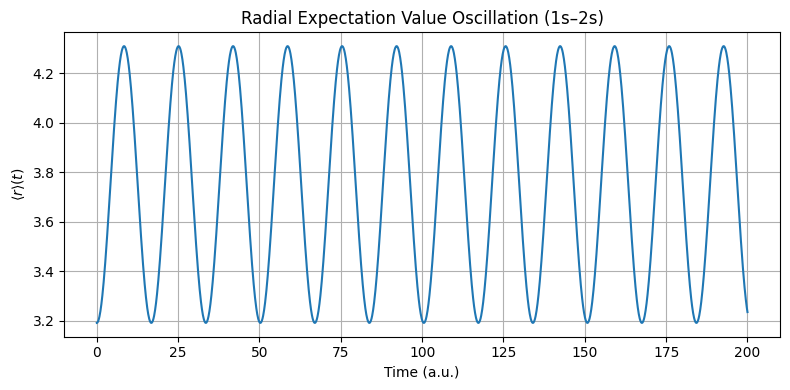

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Energies (atomic units)
# -------------------------
E1 = -0.5
E2 = -0.125
omega = E2 - E1

# -------------------------
# Radial grid
# -------------------------
r = np.linspace(0, 40, 4000)
dr = r[1] - r[0]

# -------------------------
# Hydrogen wavefunctions
# -------------------------
psi_1s = (1 / np.sqrt(np.pi)) * np.exp(-r)
psi_2s = (1 / (4 * np.sqrt(2 * np.pi))) * (2 - r) * np.exp(-r / 2)

# -------------------------
# Time-dependent wavefunction
# -------------------------
def psi_t(t):
    return (psi_1s * np.exp(-1j * E1 * t)
          + psi_2s * np.exp(-1j * E2 * t)) / np.sqrt(2)

# -------------------------
# Time grid
# -------------------------
t = np.linspace(0, 200, 2000)

# -------------------------
# Compute <r>(t)
# -------------------------
r_expect = []

for ti in t:
    psi = psi_t(ti)
    density = np.abs(psi)**2
    r_exp = np.sum(density * r * 4*np.pi*r**2) * dr
    r_expect.append(r_exp)

r_expect = np.array(r_expect)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(8, 4))
plt.plot(t, r_expect)
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle r \rangle(t)$")
plt.title("Radial Expectation Value Oscillation (1s–2s)")
plt.grid(True)
plt.tight_layout()
plt.show()
